# Social Network Analysis
## Sean O'Malley

------------------------------------------------

The intent of this analysis is to be able to take a large network of undirected connections and make sense of that network, while also giving shape to the possible networks within. This entire analysis is framed as a test case for maximizing understanding of a community given minimal input. 

This analysis is of interest to me as I have most recently been volunteering, researching and practicing data science in the poorest areas of Perú, with a specific focus on the communities of Pamplona Alta and Ayaviri with the aim of __understanding urban and rural poverty__ in the developing world better. We hope to one day be able to map and __interpret community structures__ in order to help them more. 

The analysis used is __network analysis__, which comes from the concept of network (graph) theory. Network theory is the representation of symmetric relations between discrete objects. This analysis can be used to graph and understand various social and transportation networks. Primarily, network analysis helps us model relationships between entities, determine entity importance and find community structures within a network. 

The test data used is a list of __Facebook__ friend relationships from <a href="http://snap.stanford.edu/data/ego-Facebook.html">Stanford Network Analysis Project</a>, and using this data we aim to perform the following analyses:

* _Understand the Network Structure_
    * Nodes
    * Edges
    * Degree 
    * Degree Centrality
    * Betweenness Centrality
    
* _Visualize the Network_
    * Matrix
    * Circos
    * Arc

* _Find Groups Within the Network_
    * Triangles
    * Cliques
    * Maximal Cliques
    
* _Explore Subsets of Interest_

* _Determine the Network Influencers_
    * Characteristics
    * Visualize
    
* _Recommend Friend Connections_
    * Open Triangles

* _Summary_

* _Challenges & Lessons Learned_

------------------------------------------------

_The data has been anonymized by replacing the Facebook internal ids with new values_

------------------------------------------------


### __Import Packages__ : Facebook Network Analysis

In [4]:
import os
from glob import iglob
import numpy as np 
import pandas as pd
import networkx as nx
import gzip
import matplotlib.pyplot as plt

In [5]:
import nxviz as nv

### __Ingestion__ : Facebook Network Analysis

In [6]:
# Read in file, cast as string for cleaning
f = gzip.open('facebook_combined.txt.gz','rb')
content = str(f.read())
f.close()

# Clean up and cut off messy bookends
content = content[4:-8]
content = content.replace("\\n",",")
content = content.replace(" ",";")
content = content.split(";")
    
# Initialize Lists
output = []
clean = []
    
# Build list of lists
for i in content:
    x = i.split(",") 
    output.append(x)
        
# Cast as integers  
clean = [[int(x) for x in y] for y in output]

### __Understand__ : Facebook Network Analysis


In [7]:
g = nx.Graph()
g.add_edges_from(clean)

In [8]:
print("------------------------------------------")
print("The network has " + str(len(g.nodes())) + " nodes and " + str(len(g.edges())) + " edges. Confirming SNAP data structure.")
print("------------------------------------------")

------------------------------------------
The network has 4039 nodes and 88074 edges. Confirming SNAP data structure.
------------------------------------------


##### Remove Self Loops

We want to take a quick moment to find and remove any self loops. A self loop is a node connected to itself. We don't want these in our Facebook analysis because a self loop means someone who is friends with themselves. 

In [9]:
def find_selfloop_nodes(a):
    
    nodes_in_selfloops = []
    
    # Iterate over all the edges of G
    for k, v in a.edges(data=False):
        if k == v:
            nodes_in_selfloops.append(k)
            
    return nodes_in_selfloops

In [10]:
print("------------------------------------------")
print("We can see we have " + str(g.number_of_selfloops()) + " self loops that need to be removed.")
print(str(find_selfloop_nodes(g)))
print("------------------------------------------")

------------------------------------------
We can see we have 6 self loops that need to be removed.
[339, 1254, 1894, 657, 809, 2642]
------------------------------------------


In [11]:
g.remove_edges_from(g.selfloop_edges())

In [12]:
print("------------------------------------------")
print("We now have " + str(g.number_of_selfloops()) + " self loops remaining.")
print("------------------------------------------")

------------------------------------------
We now have 0 self loops remaining.
------------------------------------------


The following descriptive statistical network analysis methodologies attempt to answer the question.

___How do you determine how important a node is, or is not?___


##### Degree 

The degree of a node in a network is the number of connections it has, while the degree distribution is the probability distribution of the degrees of nodes across the entire network.

To explore the degree of nodes from a high level, I have created a UDF to find the number of nodes given a number of connections. I placed this UDF into a loop in order to get a distribution of nodes by neighbor count.

In [13]:
def nodes_with_neighbors(a,m):
    nodes = set()
    for n in a.nodes(data=False):
        if len(list(a.neighbors(n))) == m:
            nodes.add(n)
    return nodes

We need to understand the distribution of degree across nodes, meaning that we have to determine a count of nodes given a number of neighbors. To do so we placed our UDF into a loop that creates a list of node counts, given x amount of neighbors. We selected the range of 0 to 200 neighbors to visualize.

In [59]:
n = 0
neb_num = []

for n in range(201):
    x = len(nodes_with_neighbors(g, m = n))
    neb_num.append(x)
    n += 1
    
neb = pd.DataFrame()
neb['n_neighbors'] = list(range(201))
neb['n_nodes'] = neb_num

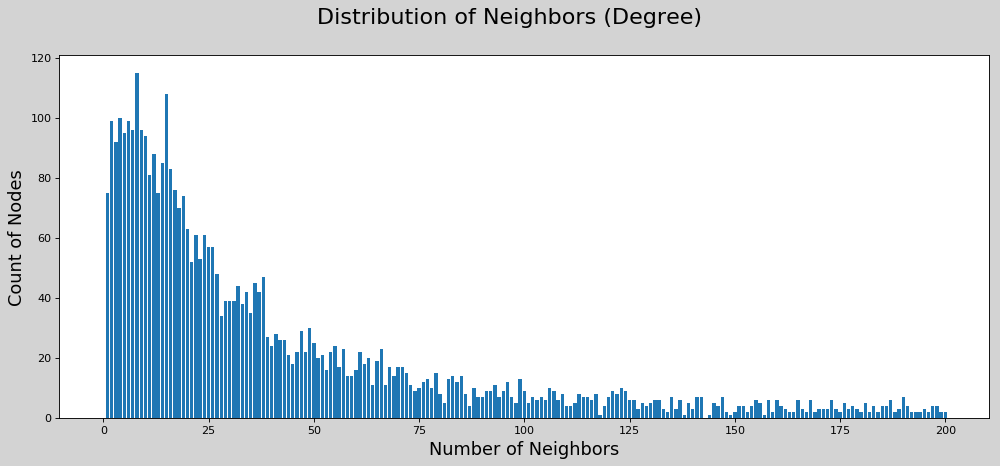

In [63]:
plt.figure(figsize=(15, 6), dpi=80, facecolor='lightgray')
plt.bar(neb['n_neighbors'],neb['n_nodes'])
plt.suptitle('Distribution of Neighbors (Degree)', fontsize=20)
plt.xlabel('Number of Neighbors', fontsize=16)
plt.ylabel('Count of Nodes', fontsize=16)
plt.show()

##### Degree Centrality

The degree centrality takes the degree process a step further, by giving an importance score based on the number of links held by each node. Providing a measure of node connectivity in a simple equation

> __degree centrality__ = number of neighbors / number of total possible neighbors

In [91]:
dc = nx.degree_centrality(g)

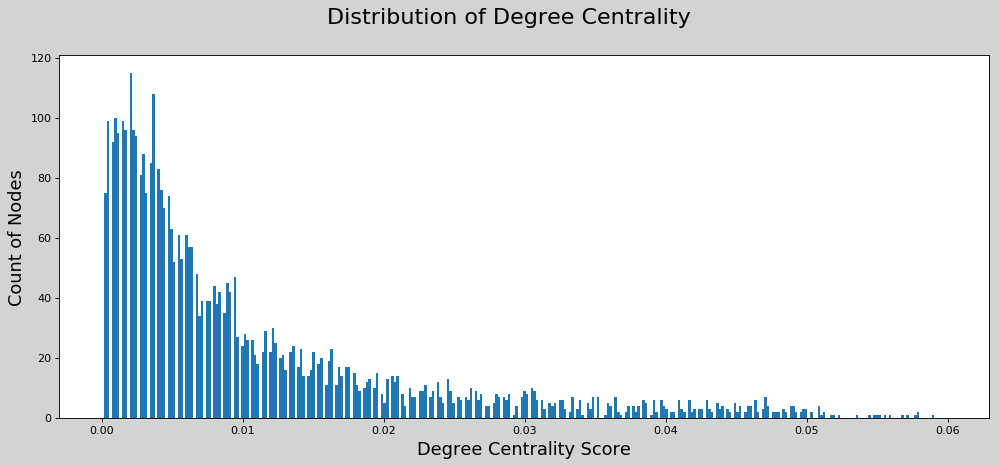

In [100]:
plt.figure(figsize=(15, 6), dpi=80, facecolor='lightgray')
plt.hist(list(dc.values()),bins = list(np.arange(0, 0.06, 0.00018)))
plt.suptitle('Distribution of Degree Centrality', fontsize=20)
plt.xlabel('Degree Centrality Score', fontsize=16)
plt.ylabel('Count of Nodes', fontsize=16)
plt.show()

##### Betweenness Centrality 

Betweenness centrality is based on the concept of the shortest path, which states, for every pair of nodes in a connected graph there is a shortest path available between the those nodes. The betweenness centrality score is a quantification of the count of shortest paths that pass through a specific node. Thus, the betweenness centrality score works as another measure for node (user) importance. 


In [175]:
bet_cen = nx.betweenness_centrality(g)

In [176]:
np.set_printoptions(suppress=True) 
bet_cen_v = list(bet_cen.values())

In [177]:
print(np.median(bet_cen_v))
print(np.mean(bet_cen_v))
print(np.mean(bet_cen_v)>np.median(bet_cen_v))

6.578615388887847e-06
0.0006389049066857799
True


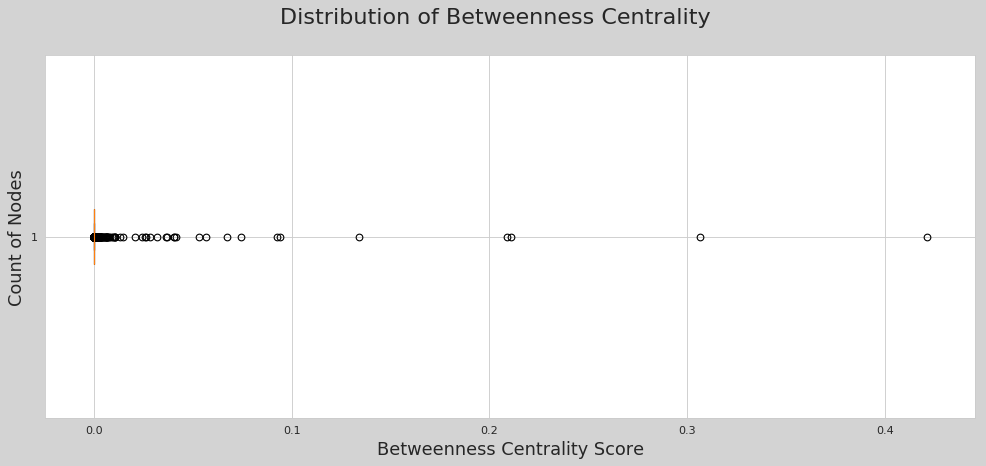

In [178]:
plt.figure(figsize=(15, 6), dpi=80, facecolor='lightgray')
plt.scatter(bet_cen_v,bet_cen_k) #, bins = list(np.arange(0, max(bet_cen_rounded), 0.0001)))
#plt.bar(bet_cen_k,bet_cen_v)
plt.boxplot(bet_cen_v, vert=False)
plt.suptitle('Distribution of Betweenness Centrality', fontsize=20)
plt.xlabel('Betweenness Centrality Score', fontsize=16)
plt.ylabel('Count of Nodes', fontsize=16)
plt.show()

This data in its most raw form is extremely difficult to understand and even more so, to gain relevant context. To highlight this I will display the matrix plot for the entire network.

To understand the general shape of the data we are to work with we will use a MatrixPlot to visualize graphs in a rational fashion. matrix plot returns the matrix form of the graph where each node is one column and one row, and an edge between the two nodes is indicated by the value 1. 

This shows that we can see there are separate groups that are largely unconnected to one another in the network. 

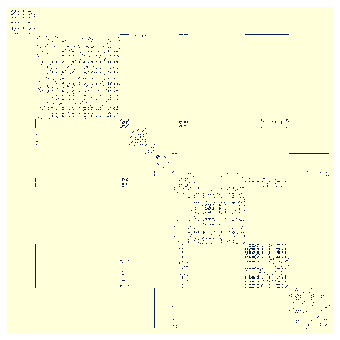

In [122]:
m = nv.MatrixPlot(g)
m.draw()
plt.show()